In [89]:
import torch
import torch.nn as nn

import numpy as np
import copy
import random

import matplotlib.pyplot as plt
import pandas as pd

In [90]:
# print the version of numpy
print("Numpy version:", np.__version__)

Numpy version: 1.24.3


In [91]:
%config InlineBackend.figure_format = 'retina'

In [92]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

In [93]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
import sine_data_generator
import models.encoder
import models.decoder

from sine_data_generator import SineDataGenerator
from models.encoder import IOPairSetEncoder
from models.decoder import Decoder
from models.lpn import LPN
from models.utils import relu_seq, ReluNet, make_leave_one_out

### Data

In [95]:
data_gen = SineDataGenerator(10, 16)

inputs_np, outputs_np, amp_np, phase_np = data = data_gen.generate()
xs, outputs_pred, amp, phase = [torch.Tensor(arr) for arr in data]

In [96]:
xs.shape, outputs_pred.shape, amp.shape, phase.shape

(torch.Size([16, 10, 1]),
 torch.Size([16, 10, 1]),
 torch.Size([16]),
 torch.Size([16]))

### Modules

#### Encoder

In [97]:
io_pairs = torch.cat([xs, outputs_pred], dim=-1)  # (batch_size, N, 2)
io_pairs.shape

torch.Size([16, 10, 2])

In [98]:
set_encoder = IOPairSetEncoder()
z_mu, z_logvar = set_encoder(io_pairs)
z_sample = z_mu
z_sample.shape  # (batch_size, output_dim)

torch.Size([16, 3])

In [99]:
set_encoder

IOPairSetEncoder(
  (phi): ReluNet(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    )
  )
  (rho_0): ReluNet(
    (net): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=16, bias=True)
    )
  )
  (rho_1): ReluNet(
    (net): Sequential(
      (0): Linear(in_features=16, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=3, bias=True)
    )
  )
  (rho_2): ReluNet(
    (net): Sequential(
      (0): Linear(in_features=16, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=3, bias=True)
    )
  )
)

#### Decoder

In [100]:
z_sample.shape, xs.shape

(torch.Size([16, 3]), torch.Size([16, 10, 1]))

In [101]:
input_0 = xs[:, 0, :]  # (batch_size, d_input)
input_0.shape

torch.Size([16, 1])

In [102]:
z_expanded = z_sample.unsqueeze(1).expand(-1, xs.size(1), -1)
z_inputs = torch.cat([z_expanded, xs], axis=-1)
z_inputs.shape

torch.Size([16, 10, 4])

In [103]:
decoder = Decoder()
decoder

Decoder(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [104]:
decoder(z_inputs).shape

torch.Size([16, 10, 1])

### Utils

In [105]:
def make_leave_one_out(array: torch.Tensor, axis: int) -> torch.Tensor:
    """
    Args:
        array: Tensor of shape (*B, N, *H).
        axis: The axis where N appears.

    Returns:
        Tensor of shape (*B, N, N-1, *H).
    """
    axis = axis % array.ndim
    n = array.size(axis)
    output = []

    for i in range(n):
        array_before = array.narrow(axis, 0, i)
        array_after = array.narrow(axis, i + 1, n - i - 1)
        sliced = torch.cat([array_before, array_after], dim=axis)
        output.append(sliced)

    output = torch.stack(output, dim=axis)
    return output

In [106]:
# Create a random tensor
random_array = torch.randn(4, 5, 6)  # Example shape (4, 5, 6)

# Apply the make_leave_one_out function
leave_one_out_result = make_leave_one_out(random_array, axis=1)

# Print the shapes to verify
print("Original shape:", random_array.shape)
print("Leave-one-out shape:", leave_one_out_result.shape)

Original shape: torch.Size([4, 5, 6])
Leave-one-out shape: torch.Size([4, 5, 4, 6])


In [107]:
random_array[0, :, :]

tensor([[-1.0116, -1.9051,  0.3487, -1.4306,  1.4125,  0.0252],
        [ 1.8755, -0.2876, -0.8023, -0.6500,  0.7096,  2.3990],
        [ 3.1756, -1.8137, -0.2817, -2.2718,  0.0576,  0.4834],
        [-0.5283,  0.4655,  0.2778,  0.2102, -0.7944,  0.9130],
        [ 0.7154, -0.1663, -1.2374, -0.8238,  0.5576, -0.6430]])

In [108]:
leave_one_out_result[0, 0, :, :]

tensor([[ 1.8755, -0.2876, -0.8023, -0.6500,  0.7096,  2.3990],
        [ 3.1756, -1.8137, -0.2817, -2.2718,  0.0576,  0.4834],
        [-0.5283,  0.4655,  0.2778,  0.2102, -0.7944,  0.9130],
        [ 0.7154, -0.1663, -1.2374, -0.8238,  0.5576, -0.6430]])

### LPN

In [109]:
# z: (H,)
# inputs: (B, 1)
B = 3  # Batch size
N = 5
H = 7  # Latent dimension

# Generate random z and inputs
z_init = torch.randn(H)  # Random latent variables of shape (B, H)
xs = torch.randn(B, 1)  # Random inputs of shape (B, 1)

# z_expanded = z.unsqueeze(0).expand(B, -1)
z_init.unsqueeze(0).expand(B, -1).shape

torch.Size([3, 7])

In [110]:
torch.manual_seed(0)
ys_1 = torch.randn(B, N, N-1, 1)
ys_2 = torch.randn(B, N, N-1, 1)
mse = nn.functional.mse_loss(ys_1, ys_2, reduction='none') # (B, N, 1)
mse.sum(dim=-2).shape

torch.Size([3, 5, 1])

In [111]:
z_init = torch.randn(B, N, H)
z_init.unsqueeze(2).expand(-1, -1, N-1, -1).shape

torch.Size([3, 5, 4, 7])

### Training

In [112]:
import wandb
wandb.init(settings=wandb.Settings(save_code=False))
wandb.finish()
wandb.init(project="lpn4sine_cf_maml")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_metaiter = 30_001
n_samples_per_task = 20
batch_size = 25

# number of inner gradient steps (in training)
numstep = 2 # changed

data_gen = SineDataGenerator(n_samples_per_task, batch_size)

# alpha = 4e-4

# Init encoder-decoder
# encoder = IOPairSetEncoder(phi=ReluNet(2, 32, 32),
#                            rho_0=ReluNet(32, 32, 16),
#                            rho_1=ReluNet(16, 8, d_latent))

# decoder = Decoder(d_input=1, d_latent=d_latent, ds_hidden=[32, 32], d_output=1)
d_latent = 2

encoder = IOPairSetEncoder(phi=ReluNet(2, 16, 32),
                           rho_0=ReluNet(32, 16, 16),
                           rho_1=ReluNet(16, 8, d_latent))

decoder = Decoder(d_input=1, 
                  d_latent=d_latent, 
                  ds_hidden=[32, 32], 
                  d_output=1)

lpn = LPN(d_input=1,
          d_output=1,
          d_latent=d_latent,
          encoder=encoder,
          decoder=decoder).to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

num_parameters = count_parameters(lpn)
print("Total parameters:", count_parameters(lpn))

optimizer = torch.optim.AdamW(lpn.parameters(), lr=1e-3)

losses = []

for i in range(n_metaiter):
    lpn.train()
    optimizer.zero_grad()

    xs, ys, amp, phase = data_gen.generate()
    io_pairs = torch.cat([xs, ys], dim=-1).to(device)  # (B, N, 2)

    # keep randomness in training
    _, loss = lpn(io_pairs, K=numstep, debug=(i==0), deterministic=False) # changed to non-deterministic

    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        wandb.log({"loss": loss.item()})
        losses.append(loss.item())
    if i % 1000 == 0:
        print(f"Step {i}, Loss: {loss.item():.4f}")


wandb.finish()

Total parameters: 2917
torch.sum(mse).item()=25427.36328125
torch.sum(mse).item()=25426.9609375
Step 0, Loss: 1.3348
Step 1000, Loss: 1.5101
Step 2000, Loss: 0.4261
Step 3000, Loss: 0.1995
Step 4000, Loss: 0.1062
Step 5000, Loss: 0.0908
Step 6000, Loss: 0.0692
Step 7000, Loss: 0.1101
Step 8000, Loss: 0.0470
Step 9000, Loss: 0.0598
Step 10000, Loss: 0.0834
Step 11000, Loss: 0.0363
Step 12000, Loss: 0.0752
Step 13000, Loss: 0.0348
Step 14000, Loss: 0.0553
Step 15000, Loss: 0.0447
Step 16000, Loss: 0.0522
Step 17000, Loss: 0.0280
Step 18000, Loss: 0.0562
Step 19000, Loss: 0.0263
Step 20000, Loss: 0.0414
Step 21000, Loss: 0.0277
Step 22000, Loss: 0.0531
Step 23000, Loss: 0.0341
Step 24000, Loss: 0.0452
Step 25000, Loss: 0.0482
Step 26000, Loss: 0.0336
Step 27000, Loss: 0.0257
Step 28000, Loss: 0.0303
Step 29000, Loss: 0.0222
Step 30000, Loss: 0.0336


loss,█▄▆▇▄▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.03364


In [113]:
wandb.finish()

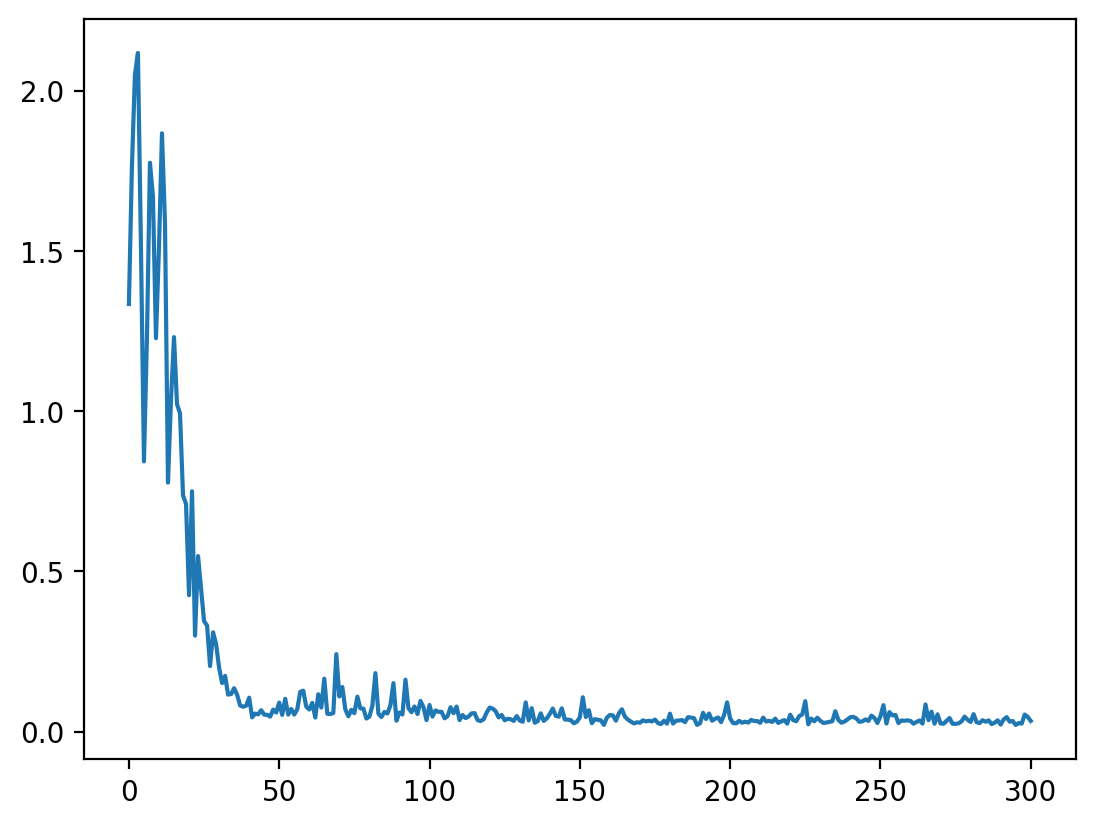

In [114]:
plt.plot(losses)
plt.show()

#### Testing: cf MAML

In [115]:
n_test_points = 60
test_batch_size = 1
n_test_samples_per_task = 20
n_support_samples_per_task = 10
n_query_samples_per_task = n_test_samples_per_task - n_support_samples_per_task

test_numstep = 10 #100

data_gen = SineDataGenerator(n_test_samples_per_task, test_batch_size)

np.random.seed(1)
random.seed(1)

metaeval_losses = np.full((n_test_points, test_numstep + 1), np.nan)

for i_test_task in range(n_test_points):
    test_xs, test_ys, amp, phase = data_gen.generate()
    support_xs = test_xs[:, :n_support_samples_per_task, :]
    support_ys = test_ys[:, :n_support_samples_per_task, :]
    query_xs = test_xs[:, n_support_samples_per_task:, :]
    query_ys = test_ys[:, n_support_samples_per_task:, :]

    support_pairs = torch.cat([support_xs, support_ys], dim=-1).to(device)  # (B, N, 2)
    aux_t, loss_t = lpn(support_pairs, K=test_numstep, debug=True, deterministic=False) # changed to non-deterministic

    y_pred = aux_t["ys_pred"].detach().cpu().numpy()
    z_mu = aux_t["z_mu"]
    z_logvar = aux_t["z_logvar"]
    # z_sample = aux_t["z_sample"].detach()
    # z_prime = aux_t["z_prime"].detach()
    z_traj = aux_t["z_traj"]

    z_sample = z_traj[0]
    z_prime = z_traj[-1]

    assert len(z_traj) == test_numstep + 1
    for i_step, z in enumerate(z_traj):
        z = z.mean(dim=1).squeeze(0)  # (d_latent,)
        assert z.shape == (d_latent,)

        # Evaluate MSE loss of z on the query set
        assert query_xs.shape == (test_batch_size, n_query_samples_per_task, 1)
        assert query_xs.squeeze(0).shape == (test_batch_size * n_query_samples_per_task, 1)
        query_ys_pred = lpn.decode(z, query_xs.squeeze(0).to(device))
        assert query_ys_pred.shape == (test_batch_size * n_query_samples_per_task, 1)
        mse = nn.functional.mse_loss(query_ys_pred, query_ys.to(device), reduction='sum')
        metaeval_losses[i_test_task, i_step] = mse.item()



torch.sum(mse).item()=312.6544494628906
torch.sum(mse).item()=39.978092193603516
torch.sum(mse).item()=8.2479248046875
torch.sum(mse).item()=3.0886995792388916
torch.sum(mse).item()=1.5364705324172974
torch.sum(mse).item()=0.9291537404060364
torch.sum(mse).item()=0.6672877669334412
torch.sum(mse).item()=0.5487335324287415
torch.sum(mse).item()=0.4932457208633423
torch.sum(mse).item()=0.4655787944793701
torch.sum(mse).item()=258.4627685546875
torch.sum(mse).item()=32.82303237915039
torch.sum(mse).item()=5.007063388824463
torch.sum(mse).item()=1.1967049837112427
torch.sum(mse).item()=0.6100631356239319
torch.sum(mse).item()=0.4882773160934448
torch.sum(mse).item()=0.4580746293067932
torch.sum(mse).item()=0.4493337869644165
torch.sum(mse).item()=0.4466647505760193
torch.sum(mse).item()=0.4458320438861847
torch.sum(mse).item()=3.2047536373138428
torch.sum(mse).item()=0.744245171546936
torch.sum(mse).item()=0.45409950613975525
torch.sum(mse).item()=0.36681440472602844
torch.sum(mse).item()=

/var/folders/wb/9whmmh7s5bvf174ppr2jwprr0000gn/T/ipykernel_25323/3952572623.py:46: UserWarning: Using a target size (torch.Size([1, 10, 1])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = nn.functional.mse_loss(query_ys_pred, query_ys.to(device), reduction='sum')


torch.sum(mse).item()=8.963632583618164
torch.sum(mse).item()=7.579390048980713
torch.sum(mse).item()=11.65391731262207
torch.sum(mse).item()=5.611913204193115
torch.sum(mse).item()=3.1612167358398438
torch.sum(mse).item()=1.9030400514602661
torch.sum(mse).item()=1.1679118871688843
torch.sum(mse).item()=0.8645695447921753
torch.sum(mse).item()=0.7374207377433777
torch.sum(mse).item()=0.6834040880203247
torch.sum(mse).item()=0.6601179838180542
torch.sum(mse).item()=0.6499345302581787
torch.sum(mse).item()=42.45724105834961
torch.sum(mse).item()=4.118107318878174
torch.sum(mse).item()=1.1692997217178345
torch.sum(mse).item()=0.6573758721351624
torch.sum(mse).item()=0.4541570246219635
torch.sum(mse).item()=0.35606083273887634
torch.sum(mse).item()=0.3075353503227234
torch.sum(mse).item()=0.2840994894504547
torch.sum(mse).item()=0.2728755474090576
torch.sum(mse).item()=0.2682511508464813
torch.sum(mse).item()=59.88938903808594
torch.sum(mse).item()=20.539337158203125
torch.sum(mse).item()=

In [116]:
for z in z_traj:
    print(z.shape)

torch.Size([1, 10, 2])
torch.Size([1, 10, 2])
torch.Size([1, 10, 2])
torch.Size([1, 10, 2])
torch.Size([1, 10, 2])
torch.Size([1, 10, 2])
torch.Size([1, 10, 2])
torch.Size([1, 10, 2])
torch.Size([1, 10, 2])
torch.Size([1, 10, 2])
torch.Size([1, 10, 2])


/var/folders/wb/9whmmh7s5bvf174ppr2jwprr0000gn/T/ipykernel_25323/4106063558.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


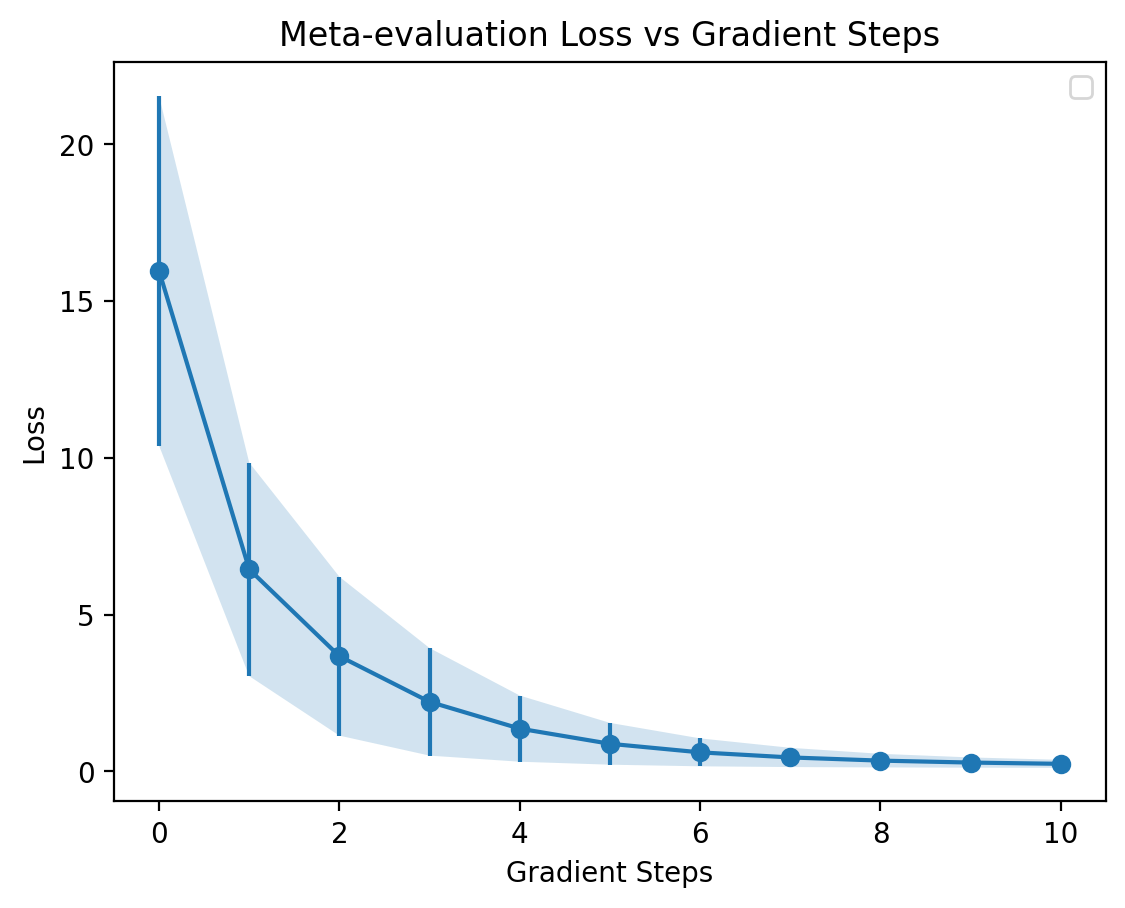

In [117]:
metaeval_mu = metaeval_losses.mean(axis=0)
assert metaeval_mu.shape == (test_numstep + 1,)
# NEW: calculate loss per MAML standard, dividing by the number of tasks
n_samples = metaeval_losses.shape[0]
metaeval_ci = 1.96 * metaeval_losses.std(axis=0) / np.sqrt(n_samples)

lower_err = np.minimum(metaeval_ci, metaeval_mu)  # ensures lower bound ≥ 0
upper_err = metaeval_ci
yerr = np.vstack([lower_err, upper_err])

x = np.arange(test_numstep + 1)
plt.errorbar(x, metaeval_mu, yerr=yerr, fmt='-o')
plt.fill_between(x, np.maximum(0, metaeval_mu - metaeval_ci), metaeval_mu + metaeval_ci, alpha=0.2)

plt.xlabel('Gradient Steps')
plt.ylabel('Loss')
plt.title('Meta-evaluation Loss vs Gradient Steps')
plt.legend()
plt.show()

In [118]:
eval_df = pd.DataFrame({"mu": metaeval_mu, "ci": metaeval_ci, "num_parameters": num_parameters})

eval_df.to_csv("..//eval_data/LPN_eval_tuned2_non_deterministic.csv")

In [119]:
metaeval_mu

array([15.96550468,  6.44194399,  3.6721551 ,  2.21654986,  1.36188855,
        0.87863015,  0.60559504,  0.44354627,  0.34203017,  0.28007052,
        0.23923104])

In [120]:
metaeval_mu

array([15.96550468,  6.44194399,  3.6721551 ,  2.21654986,  1.36188855,
        0.87863015,  0.60559504,  0.44354627,  0.34203017,  0.28007052,
        0.23923104])

In [121]:
metaeval_ci

array([5.57598742, 3.40469317, 2.53323682, 1.71475382, 1.05534439,
       0.66657804, 0.44517148, 0.30699299, 0.21676981, 0.16369708,
       0.12772086])

### Save/reload weights

In [122]:
torch.save(lpn.state_dict(), f'lpn_H{d_latent}_GA{numstep}_cmp.pth')

In [123]:
lpn = LPN(d_input=1,
          d_output=1,
          d_latent=d_latent,
          encoder=encoder,
          decoder=decoder).to(device)
state_dict = torch.load(f'lpn_H{d_latent}_GA{numstep}_cmp.pth')
lpn.load_state_dict(state_dict, strict=False)

<All keys matched successfully>

### Micro-validation

In [124]:
# one batch, 10 examples
test_xs, test_ys, amp, phase = SineDataGenerator(10, 1).generate()

amp = amp.item()
phase = phase.item()

test_xs.shape

torch.Size([1, 10, 1])

In [125]:
io_pairs_t = torch.cat([test_xs, test_ys], dim=-1).to(device)  # (B, N, 2)
aux_t, loss_t = lpn(io_pairs_t, K=200, debug=True, deterministic=False)

y_pred = aux_t["ys_pred"].detach().cpu().numpy()
z_mu = aux_t["z_mu"].detach()
z_logvar = aux_t["z_logvar"].detach()
z_sample = aux_t["z_sample"].detach()
z_prime = aux_t["z_prime"].detach()

torch.sum(mse).item()=1522.8587646484375
torch.sum(mse).item()=500.18109130859375
torch.sum(mse).item()=125.15442657470703
torch.sum(mse).item()=54.87019729614258
torch.sum(mse).item()=31.72444725036621
torch.sum(mse).item()=20.112812042236328
torch.sum(mse).item()=13.41828441619873
torch.sum(mse).item()=9.46908950805664
torch.sum(mse).item()=6.839929580688477
torch.sum(mse).item()=5.029145240783691
torch.sum(mse).item()=3.780230760574341
torch.sum(mse).item()=2.90452241897583
torch.sum(mse).item()=2.28123140335083
torch.sum(mse).item()=1.8358889818191528
torch.sum(mse).item()=1.5230697393417358
torch.sum(mse).item()=1.3022606372833252
torch.sum(mse).item()=1.1426527500152588
torch.sum(mse).item()=1.0289145708084106
torch.sum(mse).item()=0.9474047422409058
torch.sum(mse).item()=0.8886085152626038
torch.sum(mse).item()=0.8453574180603027
torch.sum(mse).item()=0.8137795329093933
torch.sum(mse).item()=0.7907422780990601
torch.sum(mse).item()=0.773568868637085
torch.sum(mse).item()=0.76106

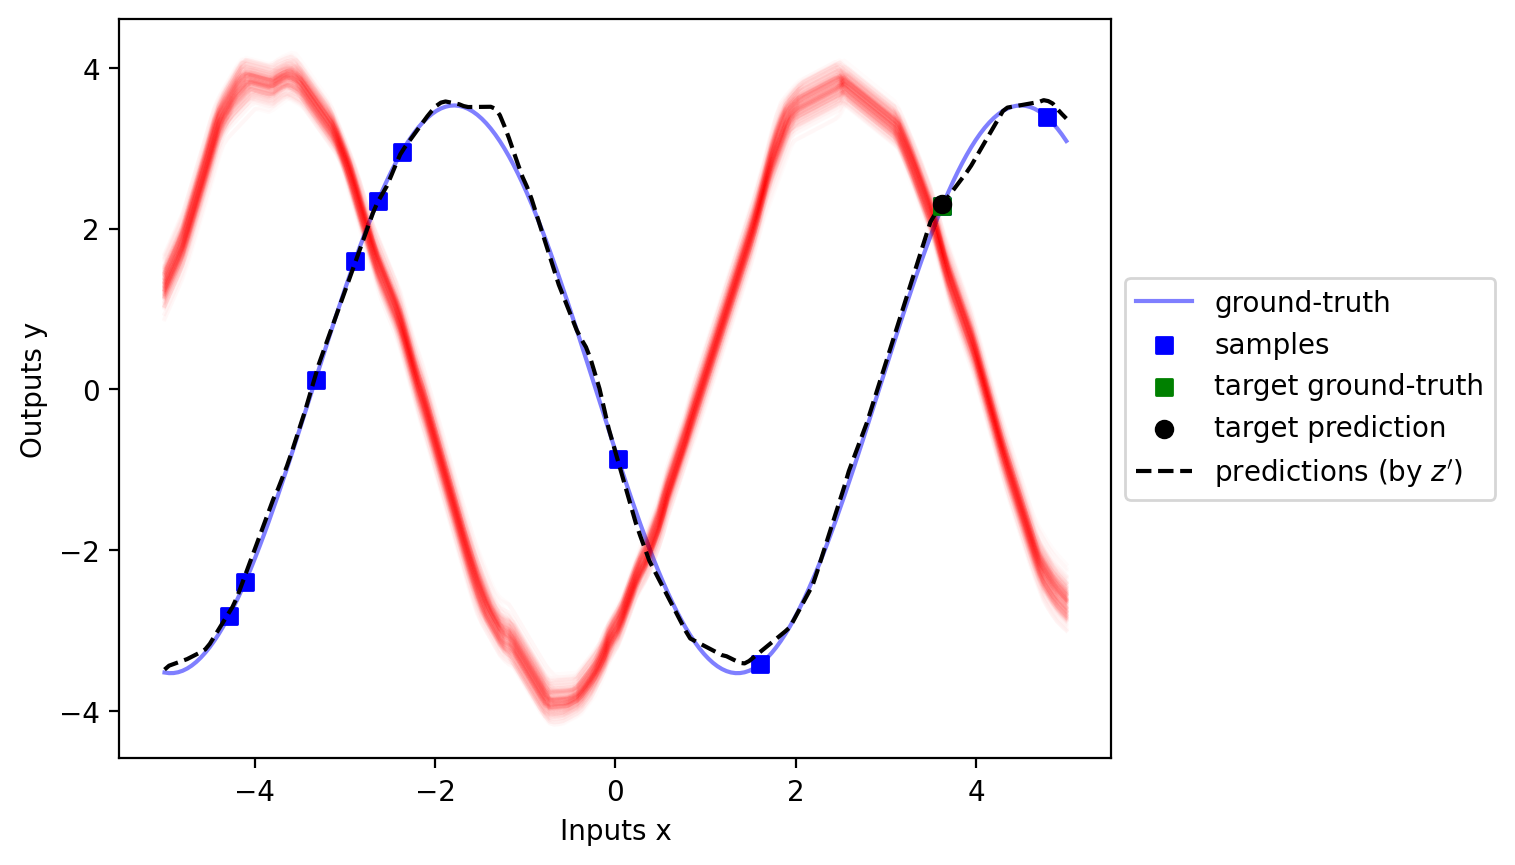

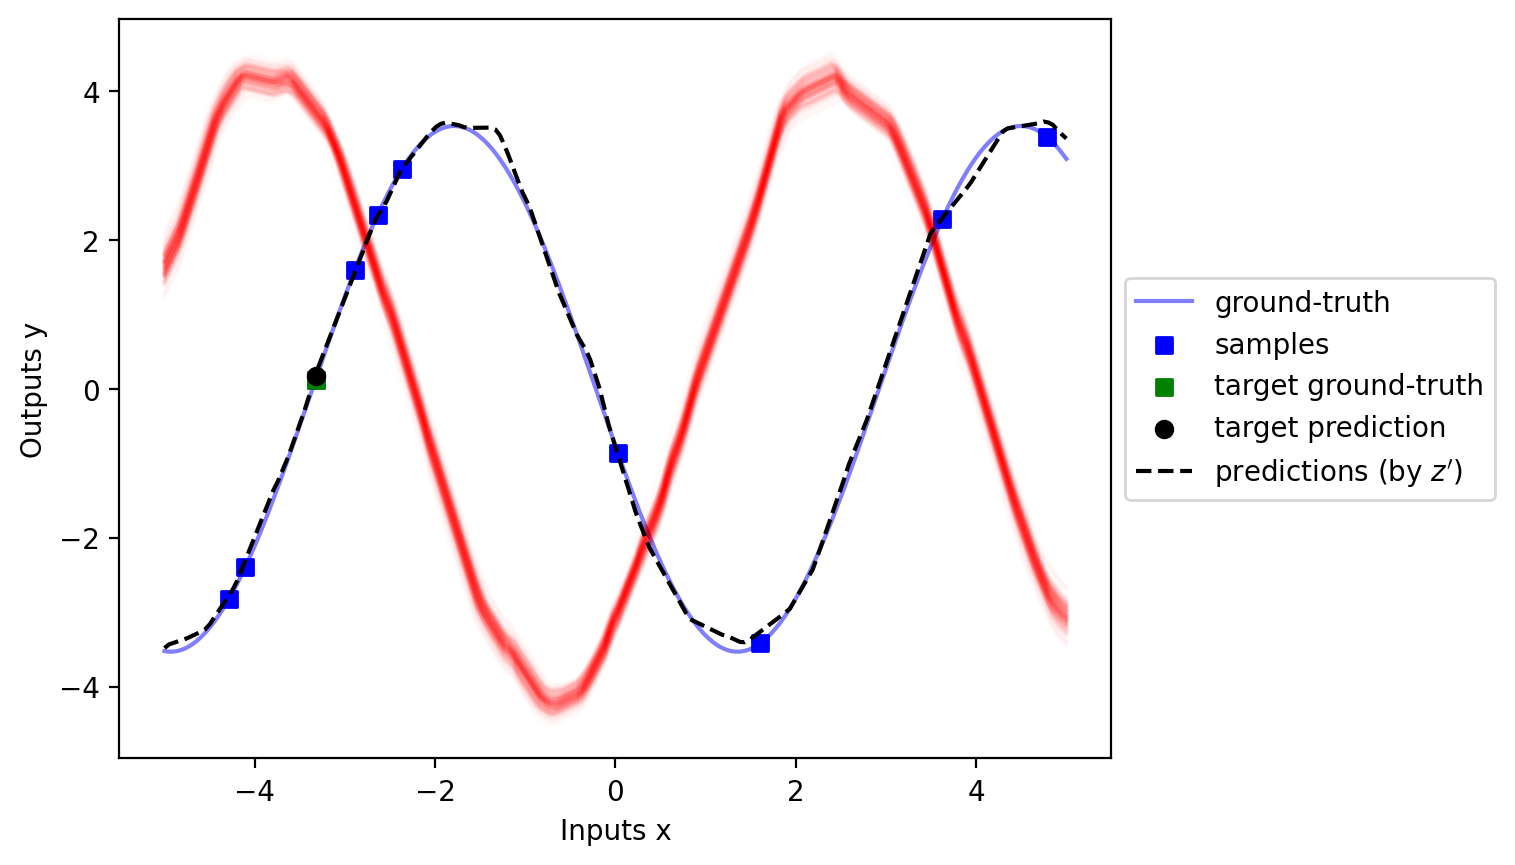

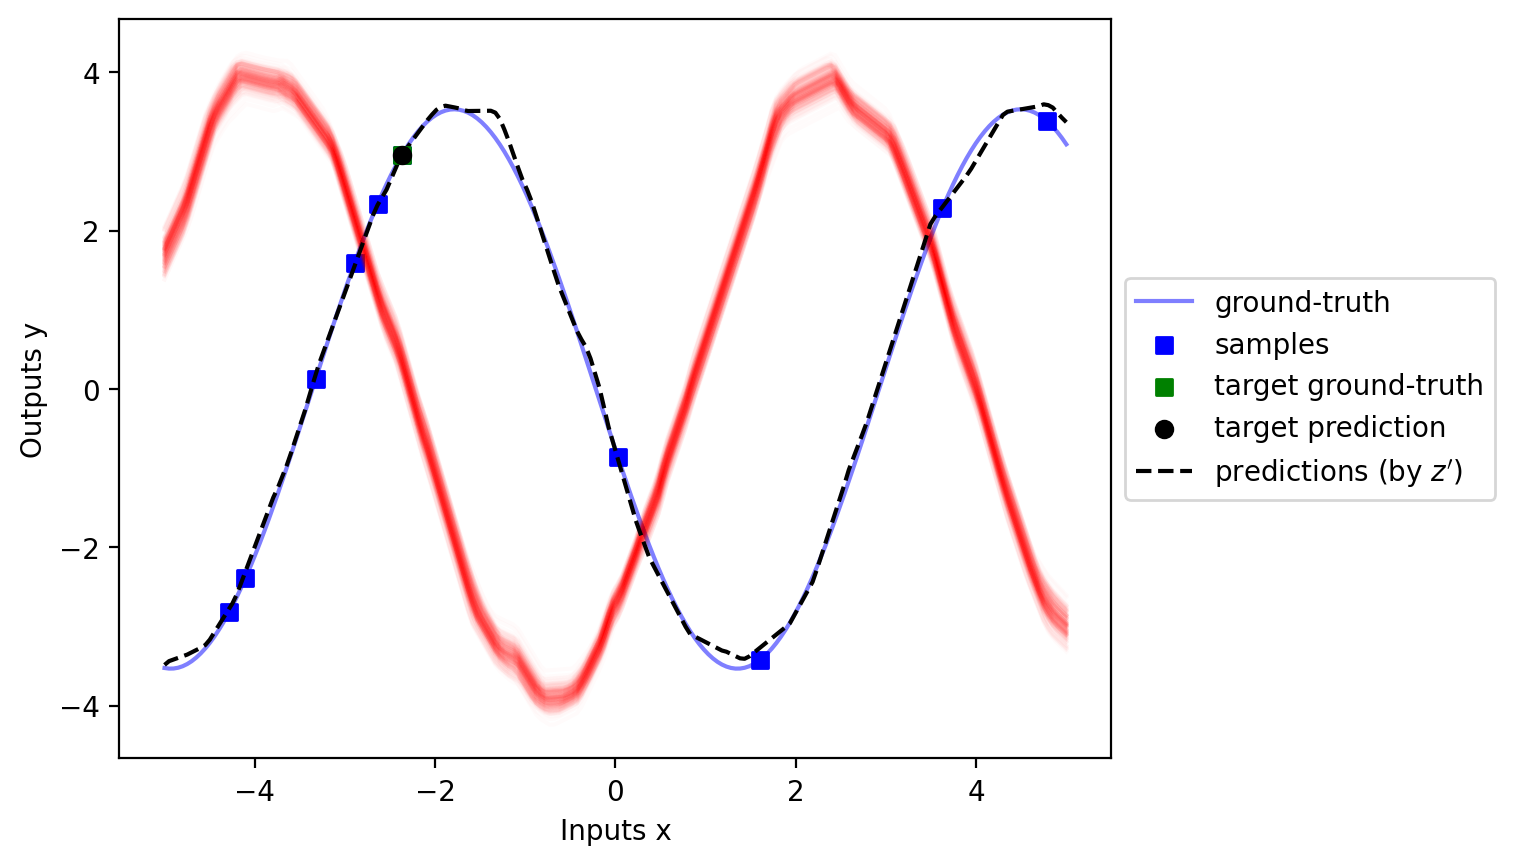

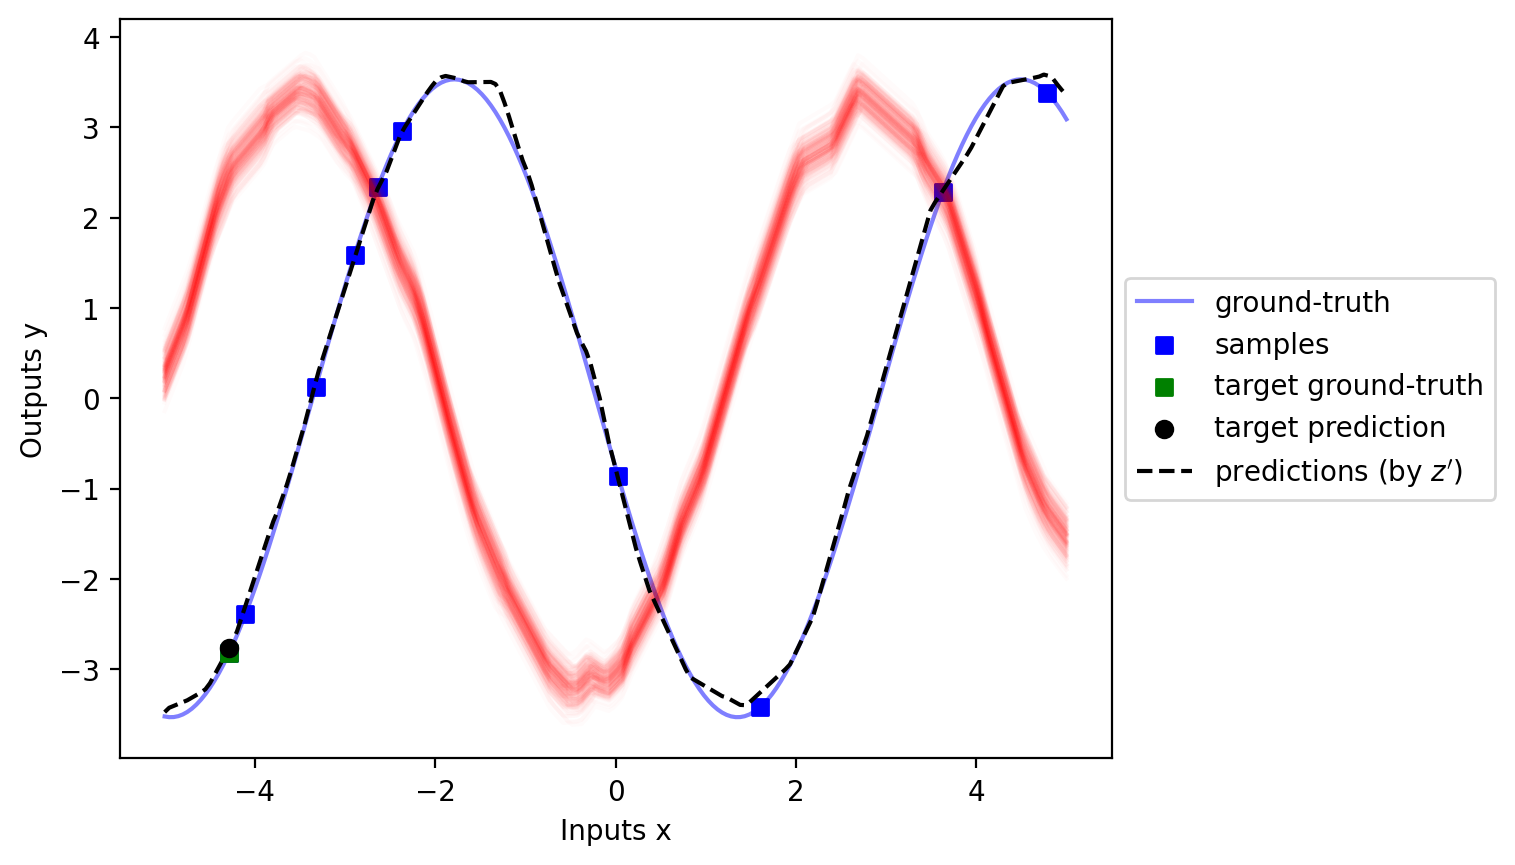

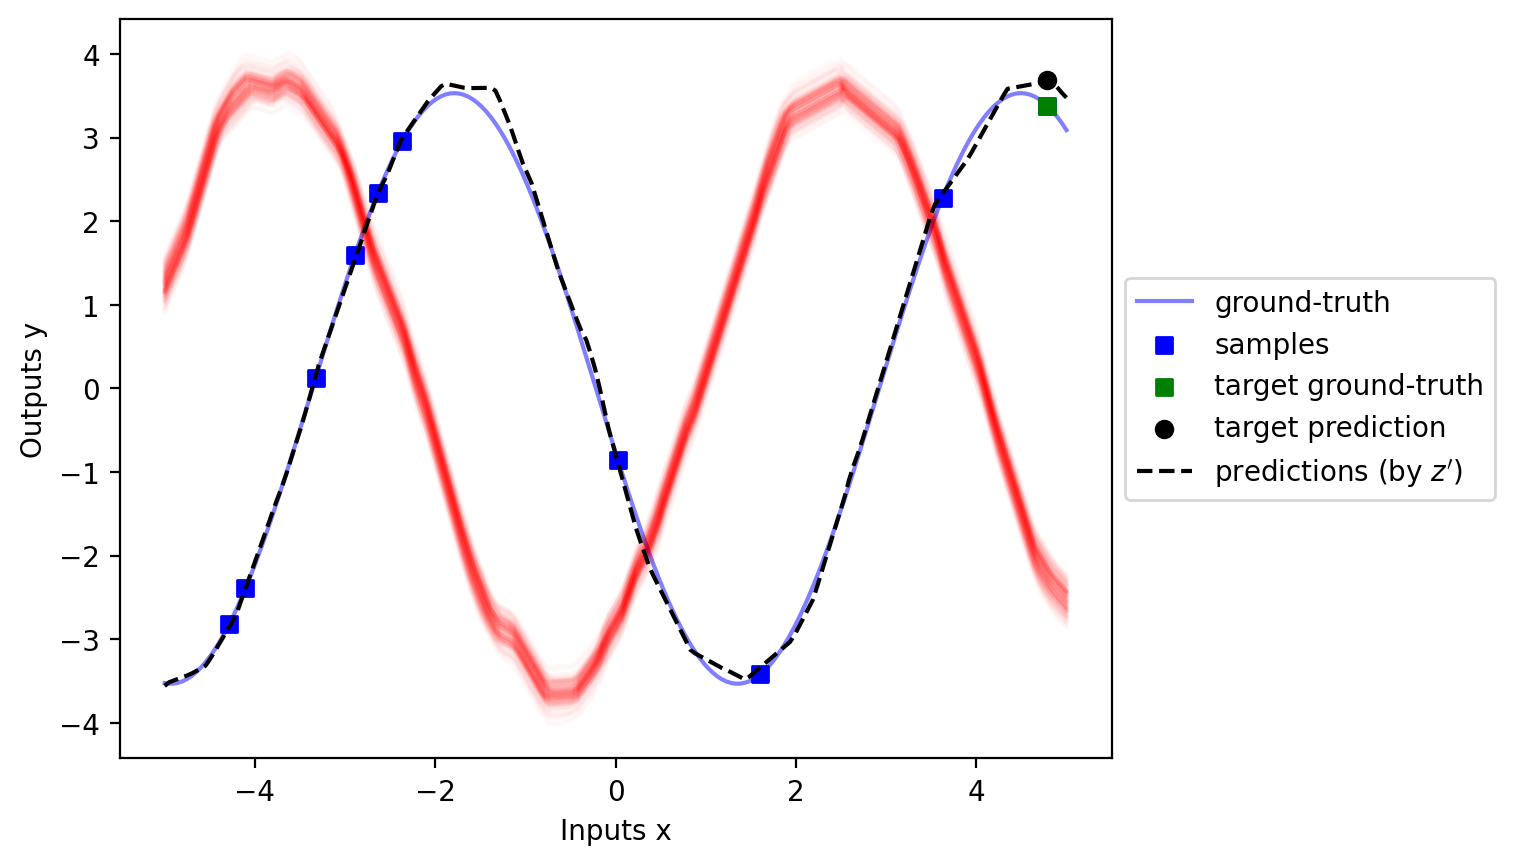

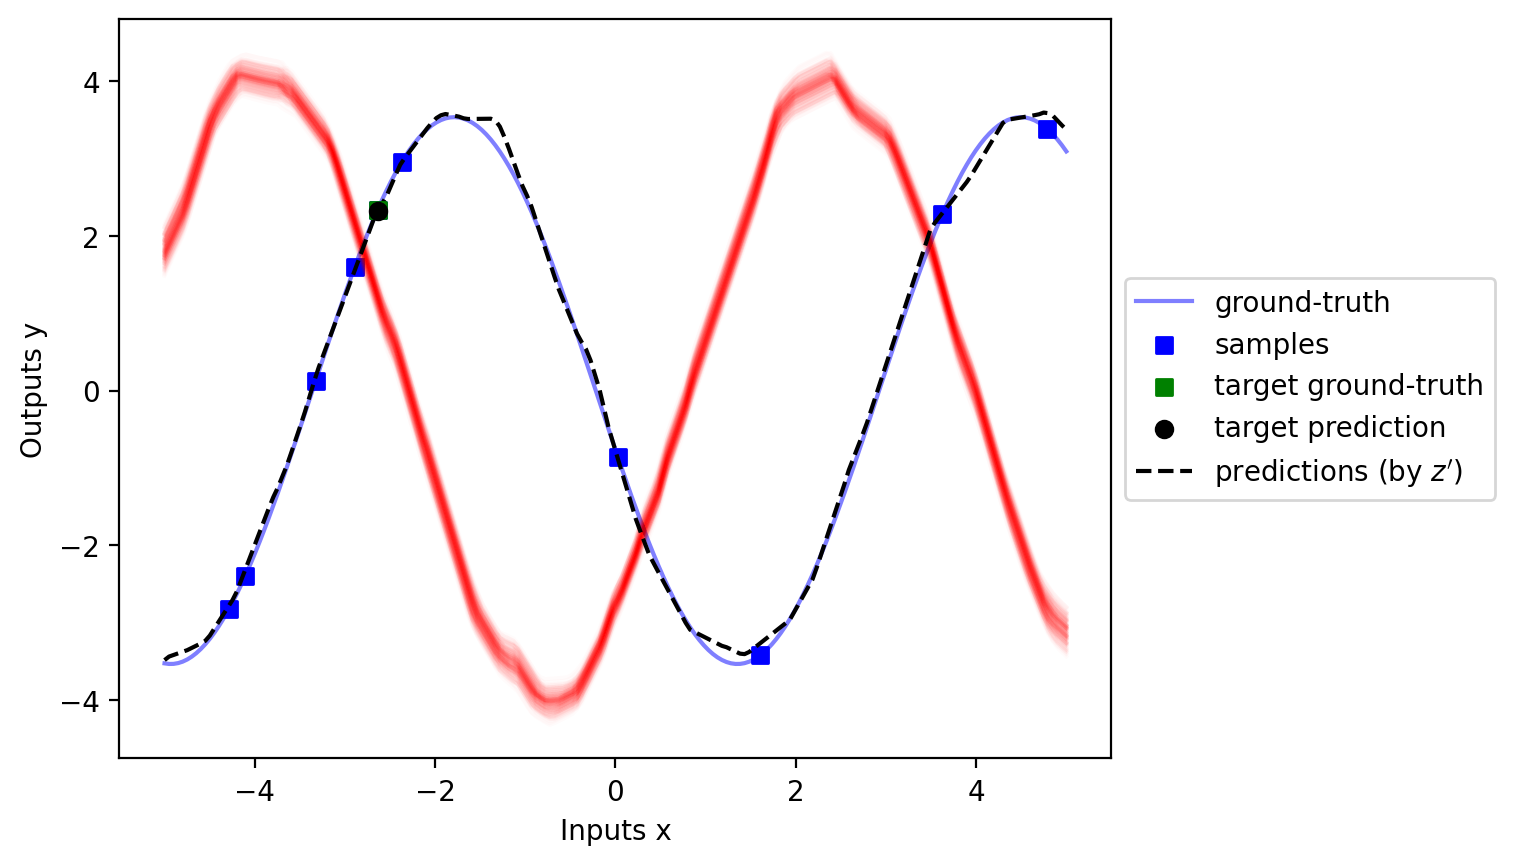

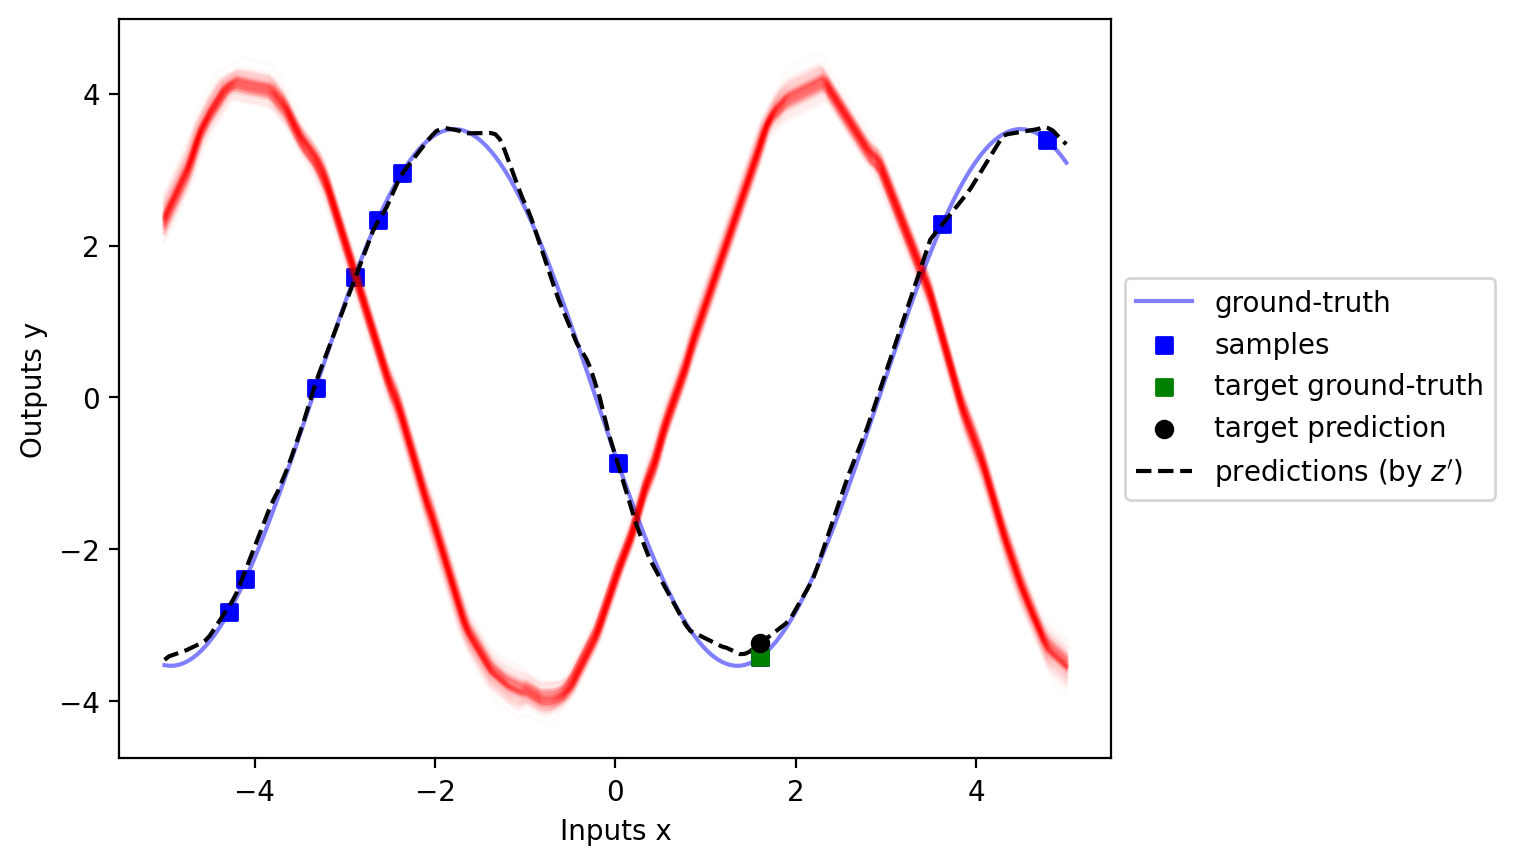

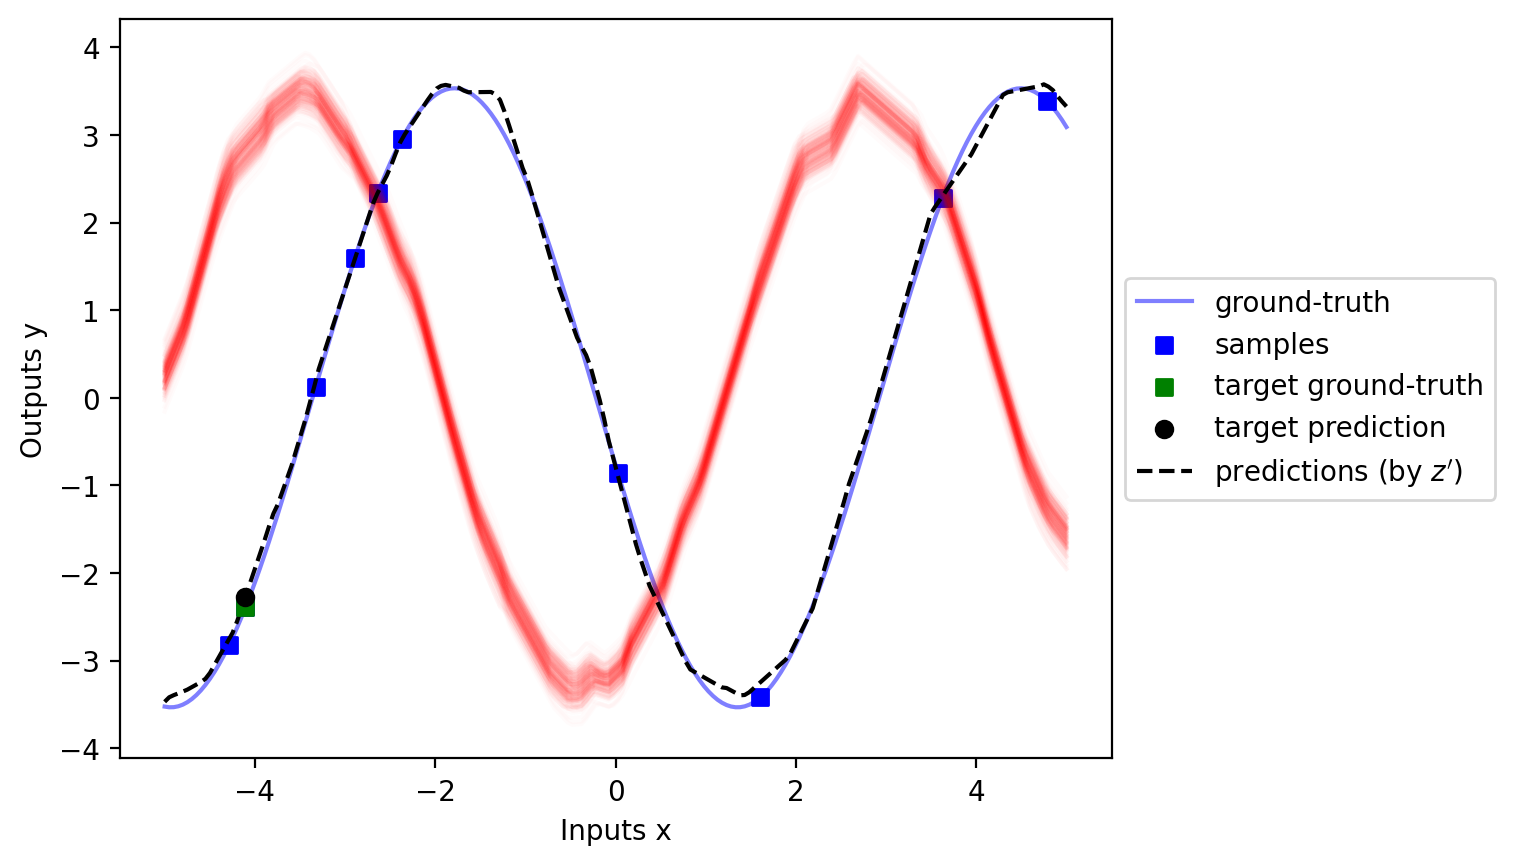

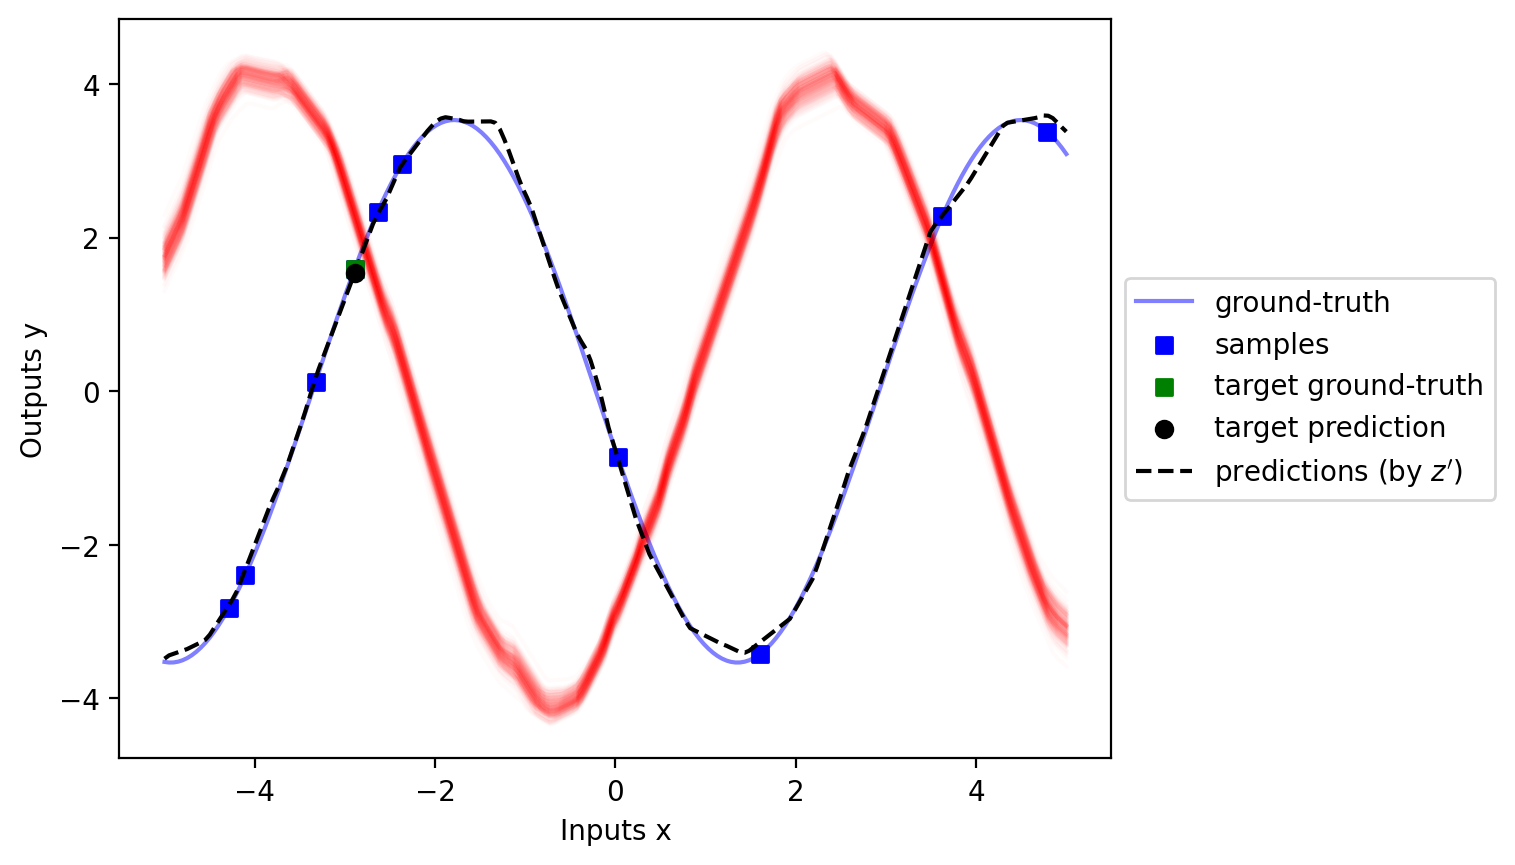

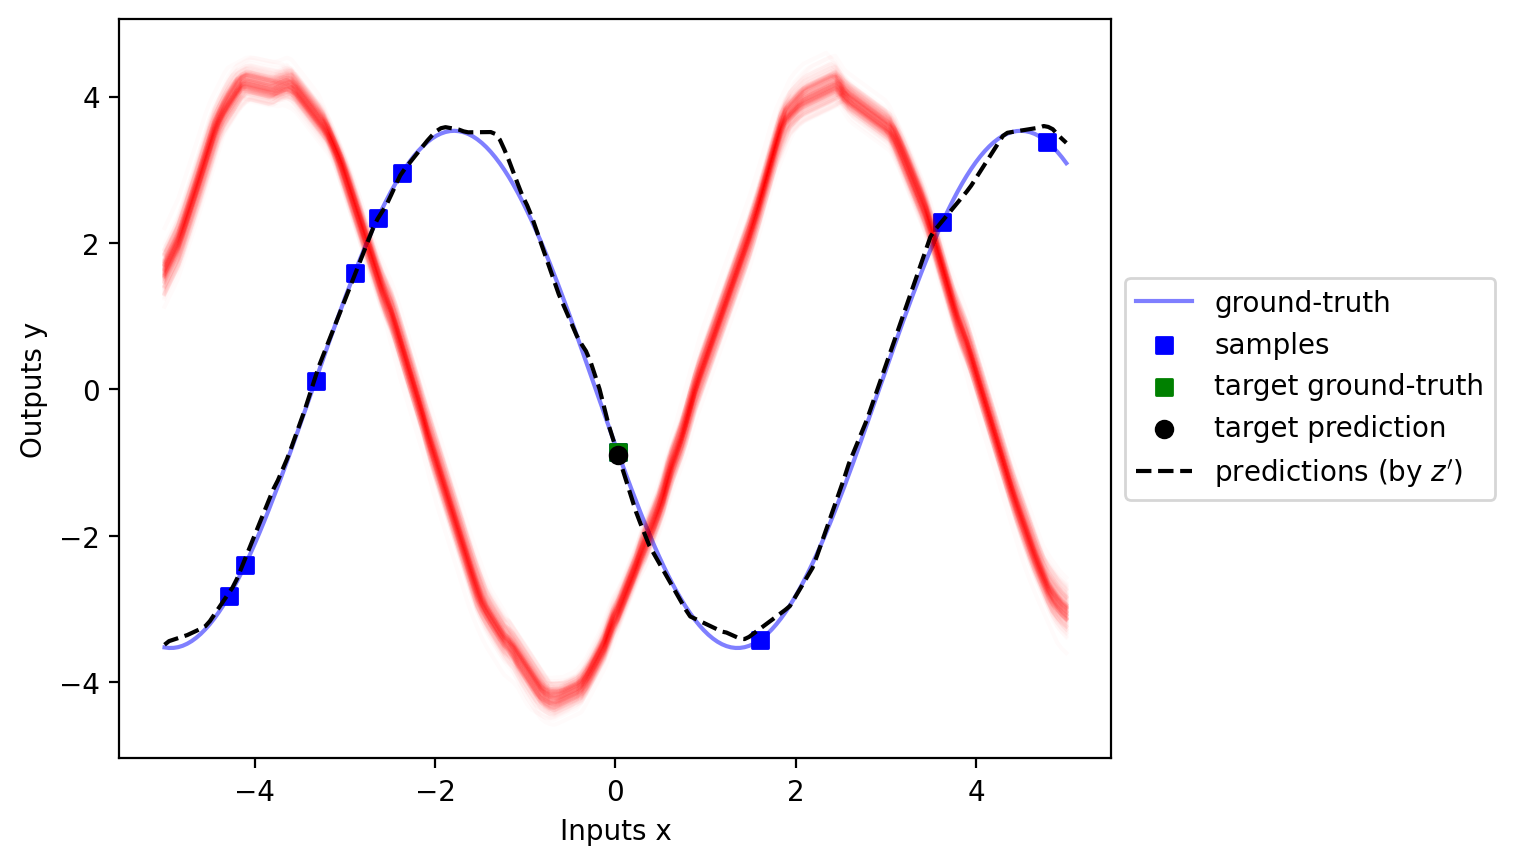

In [126]:
import matplotlib.pyplot as plt

x = np.linspace(-5, 5, 200)

for i in range(10):
    # Plot ground-truth
    y = amp * np.sin(x - phase)
    plt.plot(x, y, label=f"ground-truth", color='blue', alpha=.5, zorder=20)

    # Plot samples
    plt.scatter(test_xs, test_ys, label=f"samples", color='blue', marker='s', zorder=30)

    # Plot all predictions
    # plt.scatter(sample_xs, yhat, marker='o', color='blue', label=f"predictions")

    # Plot target x,y (sample i of batch 0), and its prediction
    x_i = test_xs[0, i].item()
    y_i = test_ys[0, i].item()
    yhat_i = y_pred[0, i].item()
    plt.scatter(x_i, y_i, marker='s', color='green', label=f"target ground-truth", zorder=60)
    plt.scatter(x_i, yhat_i, marker='o', color='k', label=f"target prediction", zorder=70)

    # Plot the predicted latent program (z_mu_i) conditioned on the 9 other samples
    z_mu_i = z_mu[0, i]
    z_pr_i = z_prime[0, i]
    x_prep = torch.Tensor(x).unsqueeze(1).to(device)  # (100, 1)
    y_pred_z_mu_i = lpn.decode(z_mu_i, x_prep).detach().cpu().numpy()
    y_pred_z_pr_i = lpn.decode(z_pr_i, x_prep).detach().cpu().numpy()
    # plt.plot(x, yhat_z_mu_i, label="predictions (by $z^{(i)}_\\mu$)",
    #          color='k', linestyle='dashed', alpha=1, zorder=50)
    plt.plot(x, y_pred_z_pr_i, label="predictions (by $z'$)",
             color='k', linestyle='dashed', alpha=1, zorder=50)

    # Plot some sampled latent programs
    n_samples = 200
    for j in range(n_samples):
        z_init = lpn.sample_latents(z_mu_i, z_logvar[0, i])
        y_pred_z = lpn.decode(z_init, x_prep).detach().cpu().numpy()
        # label = f"predictions (by $z \\sim N(\\mu_z, \\Sigma_z)$)"
        plt.plot(x, y_pred_z, color='red', alpha=3/n_samples, zorder=40)

    plt.xlabel("Inputs x")
    plt.ylabel("Outputs y")
    # plt.title("Outputs vs Inputs")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [127]:
test_xs[0, 0]

tensor([3.6262])

In [128]:
x_prep = torch.Tensor(x).unsqueeze(1).to(device)  # (100, 1)
x_prep.shape

torch.Size([200, 1])

In [129]:
z_sample[0, 0].shape

torch.Size([2])

### [WIP] Algorithm 1: Test-Time Inference

In [130]:
# # Input
# inputs, outputs_pred, amp, phase = [torch.Tensor(arr) for arr in data_gen.generate()]
# # Context: n=10 input-output pairs (x_i, y_i)
# ctx_inputs = inputs[:, :-1, :]
# ctx_outputs = outputs_pred[:, :-1, :]
# # Test input x_{n+1}
# test_inputs = inputs[:, -1, :].unsqueeze(1)
# test_outputs = outputs_pred[:, -1, :].unsqueeze(1)
# number of gradient steps

### Plotting sample tasks

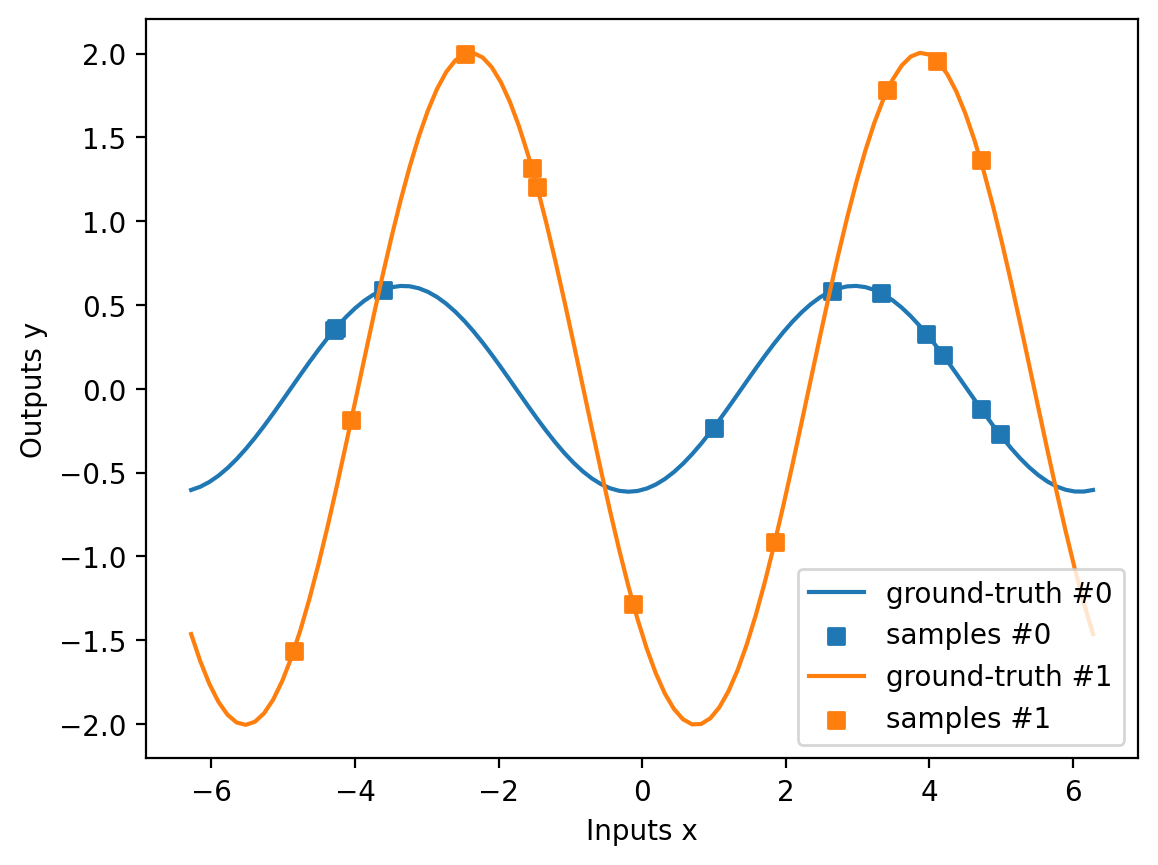

In [131]:
import matplotlib.pyplot as plt

# Plot each set of inputs and outputs as a separate line
for i in range(min(2, inputs_np.shape[0])):
    x = np.linspace(-2 * np.pi, 2 * np.pi, 100)
    
    # Convert PyTorch tensors to NumPy arrays
    if torch.is_tensor(amp_np[i]):
        amp_value = amp_np[i].detach().cpu().numpy()
    else:
        amp_value = amp_np[i]
        
    if torch.is_tensor(phase_np[i]):
        phase_value = phase_np[i].detach().cpu().numpy()
    else:
        phase_value = phase_np[i]
    
    y = amp_value * np.sin(x - phase_value)
    plt.plot(x, y, label=f"ground-truth #{i}")
    plt.scatter(inputs_np[i], outputs_np[i], marker='s', label=f"samples #{i}")

plt.xlabel("Inputs x")
plt.ylabel("Outputs y")
plt.legend()
plt.show()

In [132]:
import matplotlib.pyplot as plt
"""
# Plot each set of inputs and outputs as a separate line
for i in range(min(2, inputs_np.shape[0])):
    x = np.linspace(-2 * np.pi, 2 * np.pi, 100)
    y = amp_np[i] * np.sin(x - phase_np[i])
    plt.plot(x, y, label=f"ground-truth #{i}")
    plt.scatter(inputs_np[i], outputs_np[i], marker='s', label=f"samples #{i}")
    # plt.plot(init_inputs[i], outputs[i], label=f"Line {i+1}")

plt.xlabel("Inputs x")
plt.ylabel("Outputs y")
# plt.title("Outputs vs Inputs")
plt.legend()
plt.show()

"""

'\n# Plot each set of inputs and outputs as a separate line\nfor i in range(min(2, inputs_np.shape[0])):\n    x = np.linspace(-2 * np.pi, 2 * np.pi, 100)\n    y = amp_np[i] * np.sin(x - phase_np[i])\n    plt.plot(x, y, label=f"ground-truth #{i}")\n    plt.scatter(inputs_np[i], outputs_np[i], marker=\'s\', label=f"samples #{i}")\n    # plt.plot(init_inputs[i], outputs[i], label=f"Line {i+1}")\n\nplt.xlabel("Inputs x")\nplt.ylabel("Outputs y")\n# plt.title("Outputs vs Inputs")\nplt.legend()\nplt.show()\n\n'